### AutoML with AutoGluon 
In this notebook, we automatically train, tune, and evaluate a wide range of machine learning models using AutoGluon. 
All it takes is minimal code and setup for AutoGluon to comparatively quickly uncover the best-performing model, comprehensively investigate, and assess each approach. This notebook can give someone an idea of how AutoGluon can simplify the ML workflow and efficiently improve model selection.

In [1]:
!pip install autogluon.tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: botocore
    Fo

In [2]:
!pip install ray==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from autogluon.tabular import TabularPredictor

In [4]:
## Set these to TRUE if you want to tune the AutoGluon (AutoML) experiment again. 
RETUNE_AUTOGLUON = False

# 1. Load Dataset

In [5]:
competition = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv').drop(columns='id')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv').drop(columns='id')

In [6]:
competition.head()

Name  Gender   Age           City Working Professional or Student  \
0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1     Vivan    Male  26.0       Varanasi            Working Professional   
2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

In [7]:
original.head()

Name  Gender  Age       City Working Professional or Student  \
0    Pooja  Female   37  Ghaziabad            Working Professional   
1  Reyansh    Male   60     Kalyan            Working Professional   
2    Manvi  Female   42     Bhopal            Working Professional   
3     Isha  Female   44      Thane            Working Professional   
4    Aarav    Male   48     Indore            Working Professional   

          Profession  Academic Pressure  Work Pressure  CGPA  \
0            Teacher                NaN            2.0   NaN   
1  Financial Analyst                NaN            4.0   NaN   
2            Teacher                NaN            2.0   NaN   
3            Teacher                NaN            3.0   NaN   
4     UX/UI Designer                NaN            4.0   NaN   

   Study Satisfaction  Job Satisfaction Sleep Duration Dietary Habits Degree  \
0                 NaN               4.0      7-8 hours       Moderate     MA   
1                 NaN               3.0      5-6 hours      Unhealthy  B.Com   
2                 NaN               3.0      5-6 hours       Moderate  M.Com   
3                 NaN               5.0      7-8 hours        Healthy     MD   
4                 NaN               3.0      7-8 hours       Moderate     BE   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No                 6                 2   
1                                   Yes                 0                 4   
2                                    No                 0                 2   
3                                   Yes                 1                 2   
4                                   Yes                 6                 5   

  Family History of Mental Illness Depression  
0                               No         No  
1                              Yes         No  
2                               No         No  
3                              Yes         No  
4                              Yes         No

In [8]:
test.head()

Name  Gender   Age           City Working Professional or Student  \
0   Shivam    Male  53.0  Visakhapatnam            Working Professional   
1    Sanya  Female  58.0        Kolkata            Working Professional   
2     Yash    Male  53.0         Jaipur            Working Professional   
3   Nalini  Female  23.0         Rajkot                         Student   
4  Shaurya    Male  47.0         Kalyan            Working Professional   

               Profession  Academic Pressure  Work Pressure  CGPA  \
0                   Judge                NaN            2.0   NaN   
1  Educational Consultant                NaN            2.0   NaN   
2                 Teacher                NaN            4.0   NaN   
3                     NaN                5.0            NaN  6.84   
4                 Teacher                NaN            5.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               5.0  Less than 5 hours       Moderate   
1                 NaN               4.0  Less than 5 hours       Moderate   
2                 NaN               1.0          7-8 hours       Moderate   
3                 1.0               NaN  More than 8 hours       Moderate   
4                 NaN               5.0          7-8 hours       Moderate   

   Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0     LLB                                    No               9.0   
1    B.Ed                                    No               6.0   
2  B.Arch                                   Yes              12.0   
3     BSc                                   Yes              10.0   
4     BCA                                   Yes               3.0   

   Financial Stress Family History of Mental Illness  
0               3.0                              Yes  
1               4.0                               No  
2               4.0                               No  
3               4.0                               No  
4               4.0                               No

In [9]:
## Encoding Yes as 1 in original data to match the representation of competition data
original["Depression"] = (original["Depression"] == "Yes").astype("int")

In [10]:
original['source'] = 'original'
competition['source'] = 'competition'

In [11]:
## combining the original and competition data for this task

df_combined=pd.concat([competition, original])
df_combined=df_combined.drop_duplicates()

In [12]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143256 entries, 0 to 2555
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   143256 non-null  object 
 1   Gender                                 143256 non-null  object 
 2   Age                                    143256 non-null  float64
 3   City                                   143256 non-null  object 
 4   Working Professional or Student        143256 non-null  object 
 5   Profession                             105953 non-null  object 
 6   Academic Pressure                      28399 non-null   float64
 7   Work Pressure                          114836 non-null  float64
 8   CGPA                                   28400 non-null   float64
 9   Study Satisfaction                     28399 non-null   float64
 10  Job Satisfaction                       114844 non-null  float64

In [13]:
## reformating the columns names to remove spaces and special characters

df_combined=df_combined.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test=test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [14]:
## processing all strings in the dataset to remove training and leading whitespaces
## and to convert all strings to lowercase

cat_cols = df_combined.dtypes[df_combined.dtypes == 'object'].index.to_list()
df_combined[cat_cols] = df_combined[cat_cols].apply(lambda x: x.str.strip().str.lower())

In [15]:
test_cat_cols = test.dtypes[test.dtypes == 'object'].index.to_list()
test[test_cat_cols] = test[test_cat_cols].apply(lambda x: x.str.strip().str.lower())

**Observations:**







* There are many missing values in the dataset. We will have to do some heavy preprocessing to make the dataset usable!


# 2. EDA

In [16]:
def create_bivariate_plots_numerical(df, target_column):

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)
        
    # setting up the matplotlib figure
    n_rows = len(numerical_cols)  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3))

    # creating bivariate plots
    for i, col in enumerate(numerical_cols):
        # Create a histogram
        sns.histplot(data=df, x=col, hue=target_column, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'{col}')

        # Create a boxplot beside the histogram
        sns.boxplot(data=df, y=col, x=target_column, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col}')

    plt.tight_layout()
    plt.show()

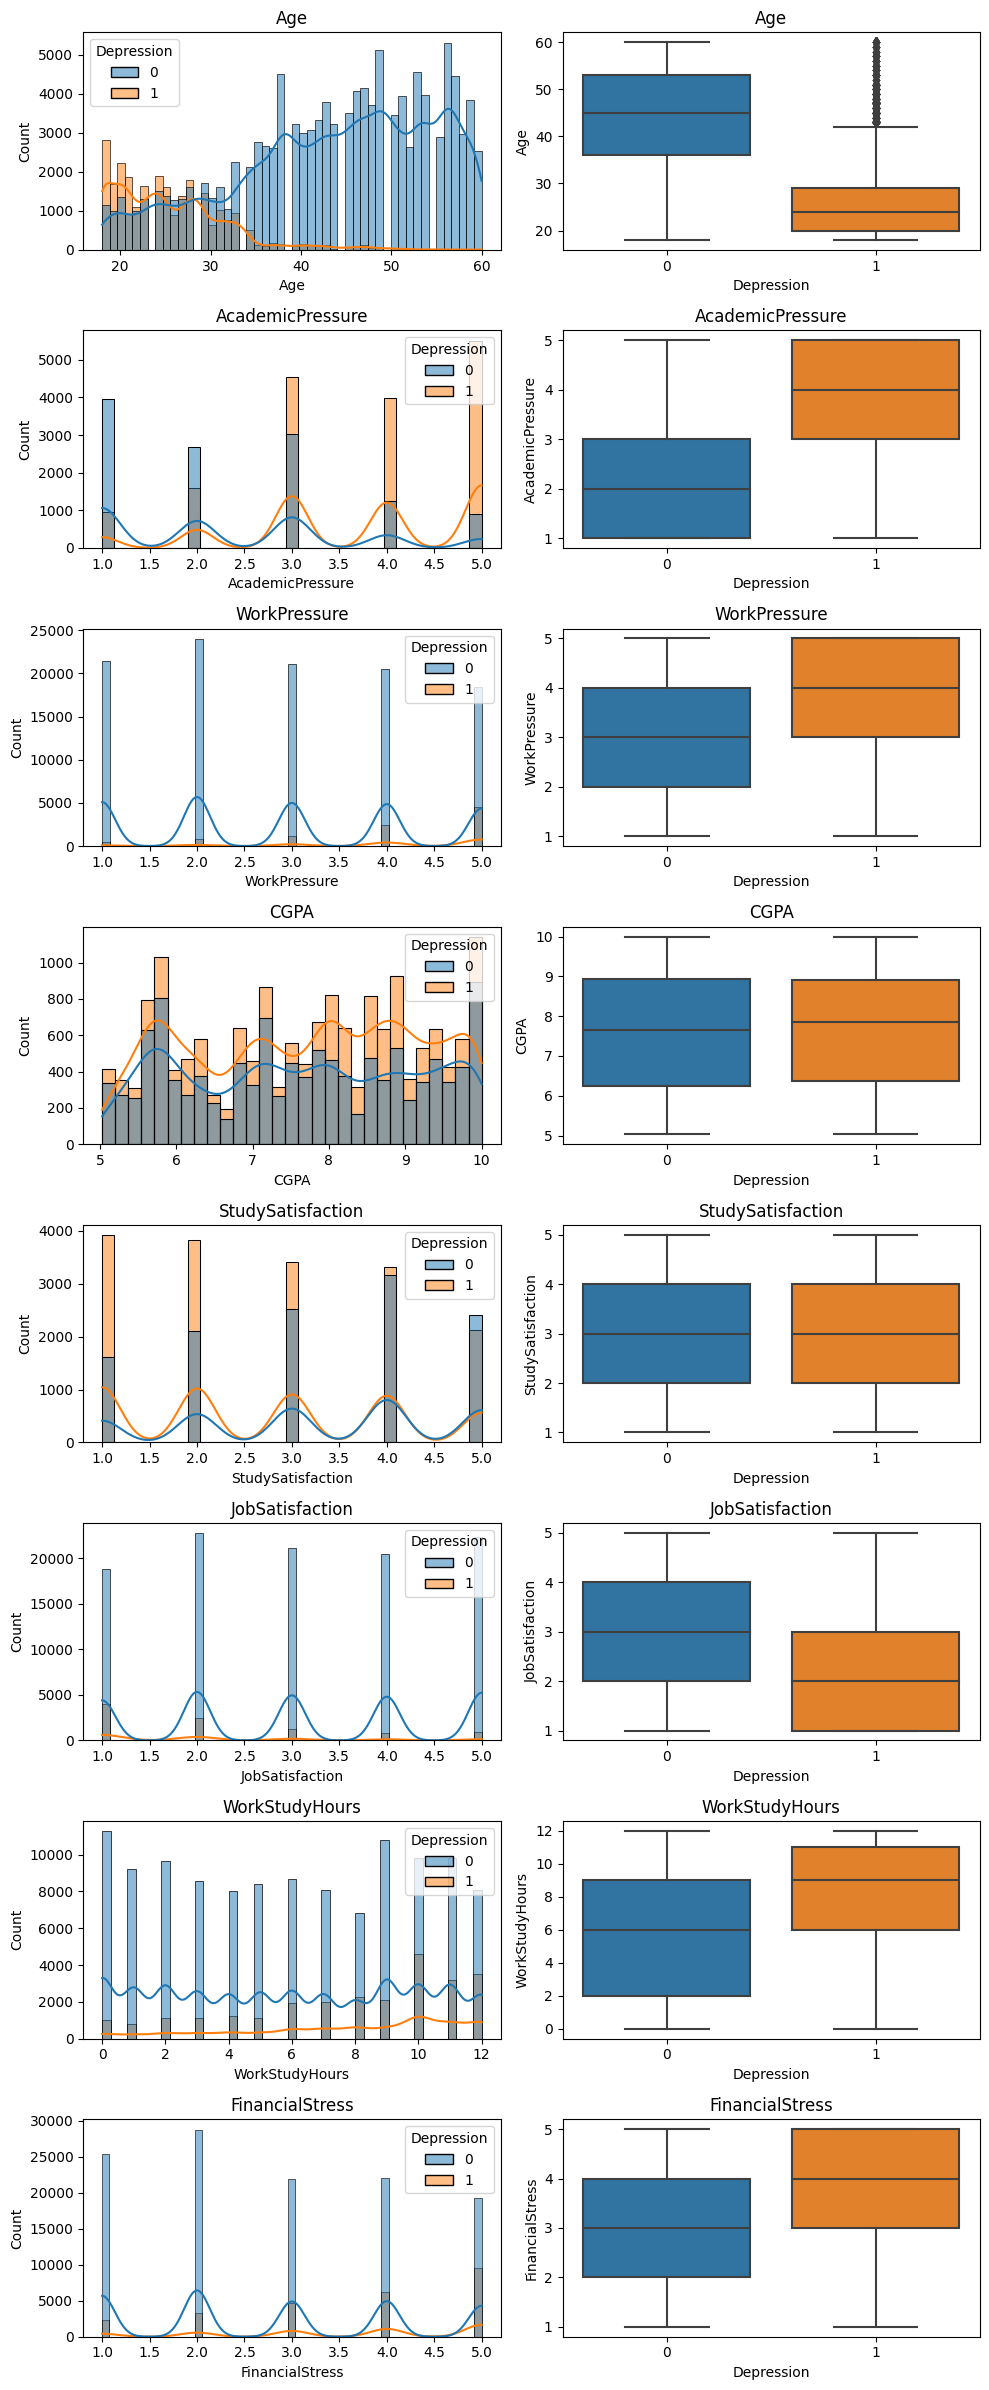

In [17]:
create_bivariate_plots_numerical(df_combined.reset_index(drop=True), 'Depression')

In [18]:
def create_bivariate_plots_categorical(df, target_column):

    # selecting categorical column names
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)

    # setting up the matplotlib figure
    n_rows = int(np.ceil(len(categorical_cols)/2))  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))

    # flatten the axes array for easy iteration
    axes = axes.flatten()
    for i, col in enumerate(categorical_cols):
        # calculating the percentage of positive target variable for each category
        percentage_df = df.groupby(col)[target_column].mean().sort_values().reset_index()
        percentage_df[target_column] = percentage_df[target_column] * 100  # convert to percentage

        # creating bar plots
        sns.barplot(data=percentage_df, x=col, y=target_column, ax = axes[i], palette='viridis')
        axes[i].set_title(f'Percentage Depression by {col}')
        axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(f'Depression %')

    plt.tight_layout()
    plt.show()

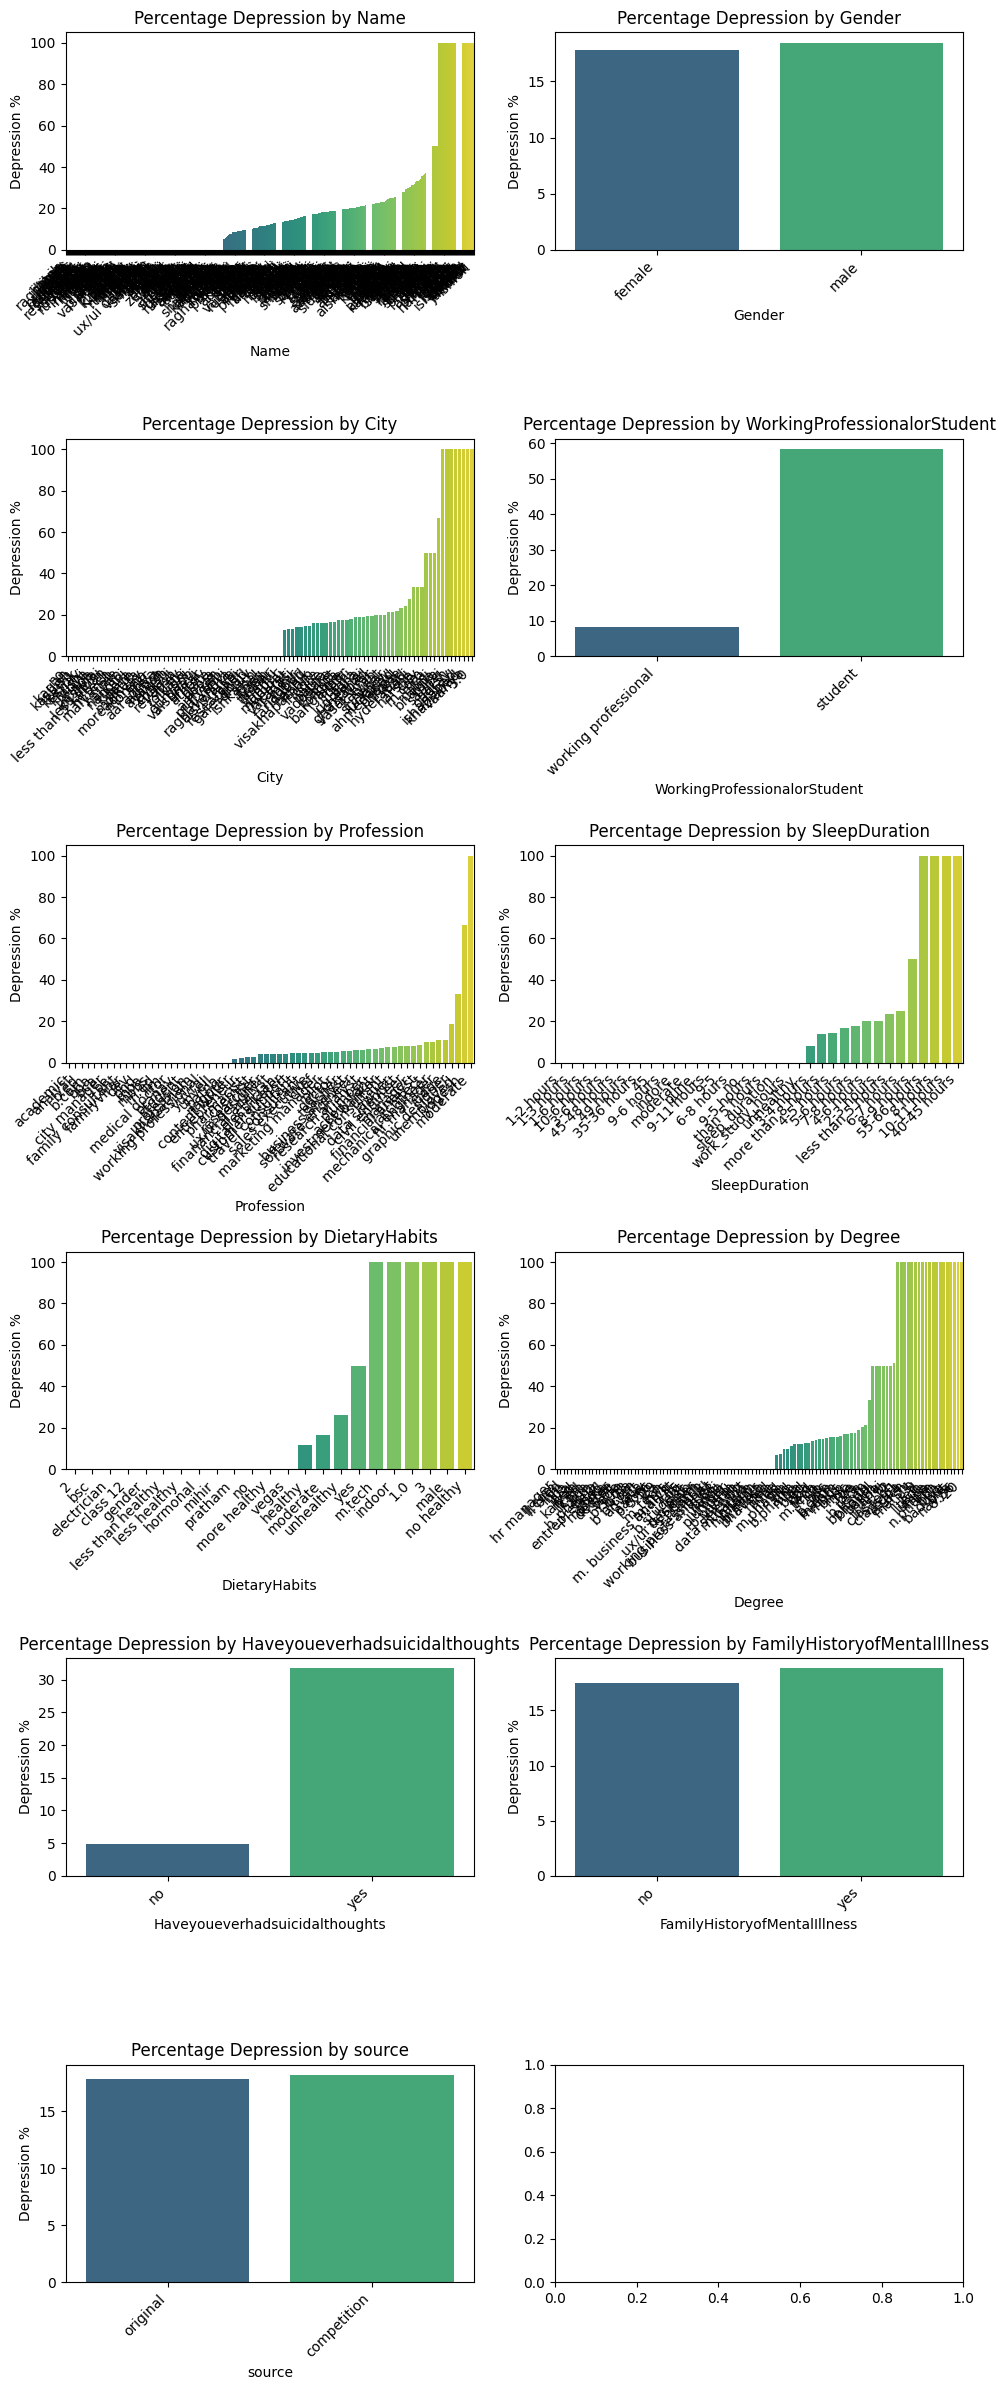

In [19]:
create_bivariate_plots_categorical(df_combined.reset_index(drop=True), 'Depression')

**Observations**



The following fields seem to have relatively stronger correlation with Depression:

* Age : Younger people are more likely to be depressed

* WorkPressure

* AcademicPressure

* WorkStudyHours

* FinancialStress

* JobSatisfaction

* StudySatisfaction

* WorkingProfessional or Student : Students are more likely to be depressed



Furthermore,  

* Some professions seem to have higer depression rate

* Some cities seem to have higer depression rate

  

# 3. Preprocessing and Feature Engineering

In [20]:
pd.set_option('display.max_rows', 250)

In [21]:
def compare_frequencies(df_combined, groupby_col, df_test=None, target = "Depression", top_n = 50):

    df1 = df_combined.groupby(groupby_col)[target].agg(['mean', 'count']).sort_values(by='count', ascending = False)[0:top_n]
    if df_test is None:
        return df1

    else:
        df2 = test.groupby(groupby_col).size().rename('count')
        df3 = pd.merge(df1, df2, how="left", left_index=True, right_index = True, suffixes = ('_train', '_test'))
        return df3

## 3.1 Processing Profession

In [22]:
## looking at the most frequent professions in the training and test data

df_profession = compare_frequencies(df_combined, "Profession", test)
df_profession

mean  count_train  count_test
Profession                                               
teacher                 0.056049        25228     16385.0
content writer          0.018916         7930      5187.0
architect               0.099482         4443      2982.0
consultant              0.047431         4301      2920.0
hr manager              0.107647         4106      2601.0
pharmacist              0.026462         3968      2656.0
doctor                  0.052996         3321      2198.0
business analyst        0.057240         3232      2186.0
entrepreneur            0.020785         3031      1935.0
chemist                 0.028090         3026      1967.0
chef                    0.049298         2921      1844.0
educational consultant  0.074931         2896      1827.0
data scientist          0.078947         2432      1582.0
researcher              0.040455         2373      1496.0
lawyer                  0.075664         2260      1497.0
customer support        0.045324         2096      1422.0
marketing manager       0.051117         2015      1284.0
pilot                   0.051742         1952      1448.0
travel consultant       0.045645         1906      1188.0
plumber                 0.064498         1783      1123.0
manager                 0.081506         1779      1155.0
sales executive         0.047431         1771      1139.0
judge                   0.109464         1754      1189.0
electrician             0.042105         1615      1121.0
financial analyst       0.083851         1610      1048.0
software engineer       0.060881         1544      1002.0
civil engineer          0.081279         1501       938.0
ux/ui designer          0.040595         1478       915.0
digital marketer        0.044904         1403       942.0
finanancial analyst     0.041697         1367       894.0
accountant              0.064897         1356       853.0
mechanical engineer     0.101906         1207       800.0
graphic designer        0.186712         1189       720.0
research analyst        0.063830          705       423.0
investment banker       0.071782          404       257.0
student                 0.000000            7         8.0
academic                0.000000            5         NaN
profession              0.000000            3         1.0
yogesh                  0.666667            3         1.0
unemployed              0.333333            3         2.0
bca                     0.000000            3         NaN
phd                     0.000000            2         1.0
mba                     0.000000            2         NaN
llm                     0.000000            2         1.0
b.com                   0.000000            1         NaN
b.ed                    0.000000            1         2.0
be                      0.000000            1         NaN
city manager            0.000000            1         NaN
familyvirar             0.000000            1         NaN
family consultant       0.000000            1         NaN

**Observation**

* It can be clearly seen that all the professions after 'investment banker' are extremely infrequent and can be considered as just noise.



* **We will remove these noisy and infrequent professions.**

In [23]:
## keeping only the professions that have at least 50 occurances in the train data

profession_features = df_profession[df_profession.count_train > 50].index.to_list()
print(profession_features)

['teacher', 'content writer', 'architect', 'consultant', 'hr manager', 'pharmacist', 'doctor', 'business analyst', 'entrepreneur', 'chemist', 'chef', 'educational consultant', 'data scientist', 'researcher', 'lawyer', 'customer support', 'marketing manager', 'pilot', 'travel consultant', 'plumber', 'manager', 'sales executive', 'judge', 'electrician', 'financial analyst', 'software engineer', 'civil engineer', 'ux/ui designer', 'digital marketer', 'finanancial analyst', 'accountant', 'mechanical engineer', 'graphic designer', 'research analyst', 'investment banker']


In [24]:
df_combined['Profession']=df_combined['Profession'].apply(lambda x: x if x in profession_features else np.nan)

In [25]:
test['Profession']=test['Profession'].apply(lambda x: x if x in profession_features else np.nan)

In [26]:
df_combined['Profession'].value_counts(dropna=False)

Profession
NaN                       37353
teacher                   25228
content writer             7930
architect                  4443
consultant                 4301
hr manager                 4106
pharmacist                 3968
doctor                     3321
business analyst           3232
entrepreneur               3031
chemist                    3026
chef                       2921
educational consultant     2896
data scientist             2432
researcher                 2373
lawyer                     2260
customer support           2096
marketing manager          2015
pilot                      1952
travel consultant          1906
plumber                    1783
manager                    1779
sales executive            1771
judge                      1754
electrician                1615
financial analyst          1610
software engineer          1544
civil engineer             1501
ux/ui designer             1478
digital marketer           1403
finanancial analyst        13



**There are other columns in the dataset that need processing similar to Profession column.Therefore, we will define a function to make this processing a bit easier:**


In [27]:
def keep_desired_features(series_combined, series_test, desired_features, replace_value = np.nan):
    series_combined = series_combined.apply(lambda x: x if x in desired_features else replace_value)
    series_test = series_test.apply(lambda x: x if x in desired_features else replace_value)    

    return series_combined, series_test

## 3.2 Processing Name

In [28]:
df_name = compare_frequencies(df_combined, "Name", test, top_n=250)
df_name

mean  count_train  count_test
Name                                          
rohan        0.140137         3204      2112.0
aarav        0.228644         2353      1499.0
rupak        0.163470         2190      1434.0
aaradhya     0.196021         2061      1423.0
anvi         0.180136         2054      1398.0
raghavendra  0.084701         1889      1305.0
vani         0.168157         1677      1100.0
tushar       0.132552         1622      1173.0
ritvik       0.228607         1601      1033.0
shiv         0.102015         1588      1033.0
rashi        0.182748         1565      1063.0
riya         0.095391         1562      1003.0
raunak       0.185065         1540       998.0
anand        0.311126         1501      1019.0
ishaani      0.146586         1494       902.0
ansh         0.152884         1439       884.0
vidya        0.200702         1425       924.0
ritika       0.125189         1326       856.0
sanya        0.146605         1296       897.0
anushka      0.213622         1292       857.0
aarush       0.250391         1278       819.0
abhishek     0.258268         1270       843.0
aariv        0.120949         1265       789.0
harsha       0.105685         1249       814.0
rupal        0.136327         1247       927.0
harsh        0.123615         1173       763.0
vikram       0.298036         1171       783.0
shivam       0.186368         1159       717.0
raghav       0.084581         1135       727.0
armaan       0.129630         1134       741.0
prachi       0.147585         1118       751.0
ivaan        0.215315         1110       696.0
siddhesh     0.194946         1108       779.0
ayaan        0.277425         1103       712.0
ira          0.214485         1077       684.0
rahil        0.243925         1070       703.0
prisha       0.200935         1070       728.0
rishi        0.115019         1052       736.0
ritik        0.102490         1044       731.0
pratham      0.091699         1036       673.0
aniket       0.204633         1036       688.0
chhavi       0.231898         1022       658.0
vibha        0.173428          986       591.0
aishwarya    0.221085          977       606.0
gauri        0.195697          976       615.0
vivan        0.187692          975       629.0
nikita       0.123061          967       598.0
naina        0.231809          962       613.0
veda         0.171039          953       683.0
arav         0.147279          937       656.0
jiya         0.218515          929       628.0
vidhi        0.208827          929       624.0
advait       0.098166          927       633.0
krishna      0.207821          895       528.0
vedant       0.167793          888       622.0
ayush        0.173273          883       597.0
aditi        0.210405          865       526.0
shaurya      0.189815          864       609.0
kashish      0.232019          862       550.0
gagan        0.226371          857       552.0
eshita       0.200236          849       577.0
pratyush     0.120773          828       539.0
ila          0.132841          813       561.0
simran       0.166460          805       517.0
shreya       0.252513          796       555.0
aadhya       0.192453          795       501.0
rudransh     0.107595          790       577.0
garima       0.087786          786       500.0
yashvi       0.152564          780       477.0
anjali       0.118799          766       513.0
vihaan       0.118421          760       512.0
keshav       0.164000          750       440.0
yuvraj       0.174497          745       472.0
tanisha      0.160000          725       494.0
sanket       0.173793          725       482.0
ishan        0.372928          724       452.0
harshil      0.090278          720       464.0
rajat        0.182197          719       512.0
kunal        0.105485          711       461.0
kiran        0.342291          707       472.0
nikhil       0.248580          704       449.0
zara         0.093525          695       475.0
aanchal      0.193642          692       456.0
shlok        0.187408 

In [29]:
name_features = df_name[df_name.count_train > 50].index.to_list()
df_combined['Name_processed'], test['Name_processed'] = keep_desired_features(df_combined['Name'], test['Name'], name_features)

## 3.3 Processing City

In [30]:
df_city = compare_frequencies(df_combined, "City", test)
df_city

mean  count_train  count_test
City                                            
kalyan         0.199162         6683      4387.0
patna          0.163479         6013      3888.0
vasai-virar    0.198294         5860      3897.0
kolkata        0.173996         5776      3726.0
ahmedabad      0.217704         5705      3677.0
meerut         0.134127         5629      3661.0
ludhiana       0.192322         5314      3545.0
pune           0.161266         5308      3318.0
rajkot         0.173298         5303      3450.0
visakhapatnam  0.159316         5260      3416.0
srinagar       0.212133         5176      3547.0
mumbai         0.131885         5065      3129.0
indore         0.161082         4954      3040.0
agra           0.191445         4769      3189.0
surat          0.201866         4716      3090.0
varanasi       0.141821         4689      3052.0
vadodara       0.167741         4656      3169.0
hyderabad      0.276141         4581      3123.0
kanpur         0.125837         4482      2978.0
jaipur         0.180354         4408      2874.0
thane          0.241703         4369      2835.0
lucknow        0.214237         4355      2860.0
nagpur         0.145323         4287      2748.0
bangalore      0.174804         4199      2707.0
chennai        0.193853         4132      2674.0
ghaziabad      0.194685         3688      2486.0
delhi          0.190346         3667      2536.0
bhopal         0.232283         3556      2370.0
faridabad      0.146663         3341      2196.0
nashik         0.159154         3217      2182.0
mihir          0.142857            7         NaN
nandini        0.000000            4         NaN
saanvi         1.000000            3         1.0
vidya          0.000000            3         4.0
harsha         0.333333            3         NaN
city           0.333333            3         2.0
mahi           0.333333            3         NaN
pratyush       0.000000            3         1.0
bhavna         0.666667            3         3.0
mca            0.500000            2         NaN
keshav         0.000000            2         2.0
nalini         0.500000            2         2.0
m.com          0.500000            2         NaN
molkata        0.000000            2         NaN
ayush          0.000000            2         NaN
atharv         0.000000            2         NaN
aditya         0.000000            1         NaN
aishwarya      0.000000            1         NaN
anvi           0.000000            1         NaN
armaan         0.000000            1         NaN

In [31]:
city_features = df_city[df_city.count_train > 50].index.to_list()
df_combined['City'], test['City'] = keep_desired_features(df_combined['City'], test['City'], city_features)

## 3.4 Processing Sleep Duration

In [32]:
df_sleep = compare_frequencies(df_combined, "SleepDuration", test)
df_sleep

mean  count_train  count_test
SleepDuration                                       
less than 5 hours  0.234378        39432     25661.0
7-8 hours          0.178250        37627     24491.0
more than 8 hours  0.138839        33348     22190.0
5-6 hours          0.165731        32770     21404.0
3-4 hours          0.083333           12         3.0
6-7 hours          0.250000            8         7.0
4-5 hours          0.142857            7         6.0
4-6 hours          0.200000            5         2.0
2-3 hours          0.200000            5         4.0
no                 0.000000            4         NaN
6-8 hours          0.000000            4         NaN
1-6 hours          0.000000            4         2.0
8-9 hours          0.500000            2         6.0
9-11 hours         0.000000            2         1.0
10-11 hours        1.000000            2         NaN
45                 0.000000            2         NaN
unhealthy          0.000000            2         1.0
sleep_duration     0.000000            2         NaN
1-2 hours          0.000000            1         2.0
1-3 hours          0.000000            1         1.0
55-66 hours        1.000000            1         NaN
49 hours           0.000000            1         NaN
45-48 hours        0.000000            1         NaN
40-45 hours        1.000000            1         NaN
3-6 hours          0.000000            1         1.0
10-6 hours         0.000000            1         1.0
35-36 hours        0.000000            1         NaN
8 hours            1.000000            1         NaN
indore             0.000000            1         NaN
9-6 hours          0.000000            1         1.0
9-5 hours          0.000000            1         2.0
9-5                0.000000            1         2.0
pune               0.000000            1         NaN
moderate           0.000000            1         NaN
than 5 hours       0.000000            1         1.0
work_study_hours   0.000000            1         NaN

In [33]:
sleep_features = df_sleep[df_sleep.count_train > 50].index.to_list()
df_combined['SleepDuration'], test['SleepDuration'] = keep_desired_features(df_combined['SleepDuration'], 
                                                                            test['SleepDuration'], 
                                                                            sleep_features
                                                                           )

## 3.5 Processing Dietary Habits

In [34]:
df_diet=compare_frequencies(df_combined, "DietaryHabits", test)
df_diet

mean  count_train  count_test
DietaryHabits                                       
moderate           0.165700        50537     33018.0
unhealthy          0.259993        47109     30786.0
healthy            0.118268        45583     29966.0
no                 0.000000            2         6.0
more healthy       0.000000            2         2.0
yes                0.500000            2         NaN
1.0                1.000000            1         1.0
gender             0.000000            1         NaN
electrician        0.000000            1         NaN
class 12           0.000000            1         NaN
bsc                0.000000            1         NaN
3                  1.000000            1         NaN
2                  0.000000            1         NaN
indoor             1.000000            1         1.0
hormonal           0.000000            1         NaN
mihir              0.000000            1         NaN
male               1.000000            1         1.0
m.tech             1.000000            1         NaN
less than healthy  0.000000            1         NaN
less healthy       0.000000            1         1.0
no healthy         1.000000            1         NaN
pratham            0.000000            1         NaN
vegas              0.000000            1         NaN

In [35]:
diet_features = df_diet[df_diet.count_train > 50].index.to_list()
df_combined['DietaryHabits'], test['DietaryHabits'] = keep_desired_features(df_combined['DietaryHabits'], 
                                                                            test['DietaryHabits'], 
                                                                            diet_features
                                                                           )

## 3.6 Processing Degree

The degree column has values with and without '.' in between. Some values are essentially the same, differing just in the presence/absence of '.'



Therefore, we will first remove all the '.' in the values.

In [36]:
# bsc = b.sc; btech = b.tech

df_combined['Degree'] = df_combined['Degree'].str.replace('.', '')
test['Degree'] = test['Degree'].str.replace('.', '')

In [37]:
df_degree=compare_frequencies(df_combined, "Degree", test)
df_degree

mean  count_train  count_test
Degree                                               
class 12            0.511530        15004      9812.0
bed                 0.128844        11805      7763.0
barch               0.157478         8833      6038.0
bcom                0.155809         8228      5439.0
bpharm              0.119913         5946      3990.0
bca                 0.203526         5842      3870.0
med                 0.098070         5751      3707.0
mca                 0.146949         5342      3438.0
bsc                 0.155152         5124      3318.0
bba                 0.134518         5122      3388.0
msc                 0.173502         4974      3096.0
llm                 0.113929         4731      3133.0
mpharm              0.098205         4623      2997.0
mtech               0.144047         4561      3017.0
btech               0.213968         4496      2889.0
llb                 0.151693         4430      2938.0
bhm                 0.171559         4395      2776.0
mba                 0.120624         3913      2470.0
ba                  0.125814         3839      2490.0
me                  0.072390         3716      2391.0
md                  0.119468         3457      2289.0
mhm                 0.070092         3367      2149.0
be                  0.190402         3188      2166.0
phd                 0.142274         3184      2073.0
mcom                0.159228         3159      2128.0
mbbs                0.170098         3157      2033.0
ma                  0.174983         2966      1933.0
march               0.000000            5         9.0
ux/ui designer      0.000000            4         NaN
m                   0.333333            3         3.0
kalyan              0.000000            3         NaN
b                   0.500000            2         2.0
llcom               0.000000            2         NaN
llba                0.500000            2         NaN
nalini              0.000000            2         NaN
jhanvi              0.500000            2         NaN
bhopal              0.500000            2         1.0
ll bed              0.000000            2         NaN
degree              0.000000            2         1.0
led                 0.000000            2         NaN
pcom                0.000000            2         NaN
lltech              1.000000            1         NaN
marsh               1.000000            1         NaN
m_tech              0.000000            1         NaN
m business analyst  0.000000            1         NaN
mahika              0.000000            1         NaN
plumber             0.000000            1         NaN
pihu                0.000000            1         NaN
npharm              1.000000            1         NaN
navya               1.000000            1         1.0

In [38]:
degree_features = df_degree[df_degree.count_train > 50].index.to_list()

df_combined['Degree'], test['Degree'] = keep_desired_features(df_combined['Degree'], 
                                                              test['Degree'], 
                                                              degree_features
                                                             )

In [39]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143256 entries, 0 to 2555
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Name                            143256 non-null  object 
 1   Gender                          143256 non-null  object 
 2   Age                             143256 non-null  float64
 3   City                            143158 non-null  object 
 4   WorkingProfessionalorStudent    143256 non-null  object 
 5   Profession                      105903 non-null  object 
 6   AcademicPressure                28399 non-null   float64
 7   WorkPressure                    114836 non-null  float64
 8   CGPA                            28400 non-null   float64
 9   StudySatisfaction               28399 non-null   float64
 10  JobSatisfaction                 114844 non-null  float64
 11  SleepDuration                   143177 non-null  object 
 12  DietaryHabits          

## 3.7 Handling Missing Values

In [40]:
df_combined.isna().sum()

Name                                   0
Gender                                 0
Age                                    0
City                                  98
WorkingProfessionalorStudent           0
Profession                         37353
AcademicPressure                  114857
WorkPressure                       28420
CGPA                              114856
StudySatisfaction                 114857
JobSatisfaction                    28412
SleepDuration                         79
DietaryHabits                         27
Degree                               103
Haveyoueverhadsuicidalthoughts         0
WorkStudyHours                         0
FinancialStress                        4
FamilyHistoryofMentalIllness           0
Depression                             0
source                                 0
Name_processed                       257
dtype: int64

#### 3.7.1  Mode Imputations

In [41]:
mode = df_combined['Name_processed'].mode()[0]
df_combined['Name_processed'] = df_combined['Name_processed'].fillna(mode)
test['Name_processed'] = test['Name_processed'].fillna(mode)

mode = df_combined['City'].mode()[0]
df_combined['City'] = df_combined['City'].fillna(mode)
test['City'] = test['City'].fillna(mode)

mode = df_combined['SleepDuration'].mode()[0]
df_combined['SleepDuration'] = df_combined['SleepDuration'].fillna(mode)
test['SleepDuration'] = test['SleepDuration'].fillna(mode)

mode = df_combined['DietaryHabits'].mode()[0]
df_combined['DietaryHabits'] = df_combined['DietaryHabits'].fillna(mode)
test['DietaryHabits'] = test['DietaryHabits'].fillna(mode)

mode = df_combined['Degree'].mode()[0]
df_combined['Degree'] = df_combined['Degree'].fillna(mode)
test['Degree'] = test['Degree'].fillna(mode)

#### 3.7.2 Median Imputations

In [42]:
## CGPA is only relevant for students.
## Therefore, marking CGPA = "None" for NON students
df_combined['CGPA']=df_combined.apply(lambda row: 'None' if (row['WorkingProfessionalorStudent'] == 'working professional') else row['CGPA'], axis =1)
test['CGPA']=test.apply(lambda row: 'None' if (row['WorkingProfessionalorStudent'] == 'working professional') else row['CGPA'], axis =1)

In [43]:
## Imputing CGPA only for students
cgpa_median=df_combined[df_combined.WorkingProfessionalorStudent == 'student']['CGPA'].median()

df_combined['CGPA'] = df_combined['CGPA'].fillna(cgpa_median)
test['CGPA'] = test['CGPA'].fillna(cgpa_median)

In [44]:
financial_stress_median=df_combined['FinancialStress'].median()
df_combined['FinancialStress'] = df_combined['FinancialStress'].fillna(financial_stress_median)
test['FinancialStress'] = test['FinancialStress'].fillna(financial_stress_median)

#### 3.7.3 Missing value as a separate category

Some columns have too many missing values. Therefore we will treat the missing values as a separate category of "values"

In [45]:
df_combined['AcademicPressure'] = df_combined['AcademicPressure'].fillna("None")
df_combined['WorkPressure'] = df_combined['WorkPressure'].fillna("None")
df_combined['StudySatisfaction'] = df_combined['StudySatisfaction'].fillna("None")
df_combined['JobSatisfaction'] = df_combined['JobSatisfaction'].fillna("None")

In [46]:
test['AcademicPressure'] = test['AcademicPressure'].fillna("None")
test['WorkPressure'] = test['WorkPressure'].fillna("None")
test['StudySatisfaction'] = test['StudySatisfaction'].fillna("None")
test['JobSatisfaction'] = test['JobSatisfaction'].fillna("None")

For profession, we will first impute missing values with the value 'student' for students.

In [47]:
df_combined['Profession']=df_combined.apply(lambda row: 'student' 
                                            if (row['WorkingProfessionalorStudent'] == 'student' 
                                                and pd.isna(row['Profession'])) 
                                            else row['Profession'], axis =1)

test['Profession']=test.apply(lambda row: 'student' 
                              if (row['WorkingProfessionalorStudent'] == 'student' 
                                  and pd.isna(row['Profession'])) 
                              else row['Profession'], axis =1)

And then, fill the rest of the missing values with "None" to mark a separate category.

In [48]:
df_combined['Profession'] = df_combined['Profession'].fillna("None")
test['Profession'] = test['Profession'].fillna("None")

## 3.8 Adding New Features

Because WorkPressure and AcademicPressure are mutually exclusive, we can combine values from WorkPressure and AcademicPressure to make a new column.

In [49]:
df_combined['Pressure'] = df_combined.apply(lambda row:
                                            row['WorkPressure'] 
                                            if row['WorkingProfessionalorStudent'] == 'working professional' 
                                            else row['AcademicPressure'] 
                                            if row['WorkingProfessionalorStudent'] == 'student' 
                                            else np.nan, axis = 1)

df_combined['Pressure'] = df_combined['Pressure'].replace("None", np.nan)

test['Pressure'] = test.apply(lambda row: 
                              row['WorkPressure'] 
                              if row['WorkingProfessionalorStudent'] == 'working professional' 
                              else row['AcademicPressure'] 
                              if row['WorkingProfessionalorStudent'] == 'student' 
                              else np.nan, axis = 1
                             )

test['Pressure'] = test['Pressure'].replace("None", np.nan)

Similarly, we can combine values from JobSatisfaction and StudySatisfaction to make a new column.

In [50]:
df_combined['Satisfaction'] = df_combined.apply(lambda row: 
                                                row['JobSatisfaction'] 
                                                if row['WorkingProfessionalorStudent'] == 'working professional' 
                                                else row['StudySatisfaction'] 
                                                if row['WorkingProfessionalorStudent'] == 'student' 
                                                else np.nan, axis = 1
                                               )

df_combined['Satisfaction'] = df_combined['Satisfaction'].replace("None", np.nan)

test['Satisfaction'] = test.apply(lambda row: 
                                  row['JobSatisfaction'] 
                                  if row['WorkingProfessionalorStudent'] == 'working professional' 
                                  else row['StudySatisfaction'] 
                                  if row['WorkingProfessionalorStudent'] == 'student' 
                                  else np.nan, axis = 1
                                 )

test['Satisfaction'] = test['Satisfaction'].replace("None", np.nan)

In [51]:
## imputing missing values with median

pressure_median=df_combined['Pressure'].median()
df_combined['Pressure'] = df_combined['Pressure'].fillna(pressure_median)
test['Pressure'] = test['Pressure'].fillna(pressure_median)

satisfaction_median=df_combined['Satisfaction'].median()
df_combined['Satisfaction'] = df_combined['Satisfaction'].fillna(satisfaction_median)
test['Satisfaction'] = test['Satisfaction'].fillna(satisfaction_median)

Defining some new features by combining Pressure, Satisfaction, and FinancialStress columns:

In [52]:
df_combined['PS_ratio']=df_combined['Pressure']/df_combined['Satisfaction']
test['PS_ratio']=test['Pressure']/test['Satisfaction']

df_combined['PSF_ratio']=df_combined['PS_ratio']*df_combined['FinancialStress']
test['PSF_ratio']=test['PS_ratio']*test['FinancialStress']

df_combined['PF_factor']=df_combined['Pressure']*df_combined['FinancialStress']
test['PF_factor']=test['Pressure']*test['FinancialStress']

## category version of PS_ratio
df_combined['PS_category'] = df_combined.apply(lambda row: str(row['Pressure']) + '_' + str(row['Satisfaction']), axis = 1)
test['PS_category'] = test.apply(lambda row: str(row['Pressure']) + '_' + str(row['Satisfaction']), axis = 1)

In [53]:
## imputing missing values with median

ps_median=df_combined['PS_ratio'].median()
df_combined['PS_ratio'] = df_combined['PS_ratio'].fillna(ps_median)
test['PS_ratio'] = test['PS_ratio'].fillna(ps_median)

psf_median=df_combined['PSF_ratio'].median()
df_combined['PSF_ratio'] = df_combined['PSF_ratio'].fillna(psf_median)
test['PSF_ratio'] = test['PSF_ratio'].fillna(psf_median)

pf_median=df_combined['PF_factor'].median()
df_combined['PF_factor'] = df_combined['PF_factor'].fillna(pf_median)
test['PF_factor'] = test['PF_factor'].fillna(pf_median)

Making a new column that categorizes Age into 15 equal sized categories:

In [54]:
df_combined['Age_bin']=pd.qcut(df_combined['Age'], 15, duplicates='drop')
age_bins = df_combined['Age_bin'].unique().categories
test['Age_bin'] = pd.cut(test['Age'], bins=age_bins)

In [55]:
df_combined.isna().sum()

Name                              0
Gender                            0
Age                               0
City                              0
WorkingProfessionalorStudent      0
Profession                        0
AcademicPressure                  0
WorkPressure                      0
CGPA                              0
StudySatisfaction                 0
JobSatisfaction                   0
SleepDuration                     0
DietaryHabits                     0
Degree                            0
Haveyoueverhadsuicidalthoughts    0
WorkStudyHours                    0
FinancialStress                   0
FamilyHistoryofMentalIllness      0
Depression                        0
source                            0
Name_processed                    0
Pressure                          0
Satisfaction                      0
PS_ratio                          0
PSF_ratio                         0
PF_factor                         0
PS_category                       0
Age_bin                     

# 4. AutoML with AutoGluon

In [56]:
train_data = df_combined.drop(columns=["source", "Name"])

test_data = df_test_processed = test.drop(columns=["Name"]).copy()

## 4.1 Training

In [57]:
# ===== AutoGluon Binary Classification Workflow =====

def autogluon_classification_workflow(train_data, test_data, target_column):

    # Initialize predictor
    predictor = TabularPredictor(
        label=target_column,
        problem_type='binary',
        eval_metric='accuracy',
        path='autogluon_models'
    )
 
    predictor.fit(
        train_data=train_data,
        time_limit=7200, ## time limit (seconds) for the experiment to run
        presets='best_quality', ## use only the best quality preset models (trade-off with training time)
        num_stack_levels=3, ## stacking levels to consider
        num_bag_folds=5, ## number of bagging folds (cv folds)
        ag_args_fit={'num_gpus': 2},
        num_gpus=2,  
        verbosity=2,
    )

    # Get leaderboard
    leaderboard = predictor.leaderboard()
    print("\nModel Leaderboard:")
    print(leaderboard)

    # Feature importance
    feature_importance = predictor.feature_importance(data=train_data)
    print("\nFeature Importance:")
    print(feature_importance)


    return predictor, leaderboard

In [58]:
## I have already run the experiment and saved the results.
## If you want to re-run the experiment, set RETUNE_AUTOGLUON = True 
## running the experimnt takes at least 2 hours

if RETUNE_AUTOGLUON == True:
    predictor, leaderboard = autogluon_classification_workflow(train_data, test_data, "Depression")

else:
    predictor = TabularPredictor.load('/kaggle/input/pgs4e11-autogluon-models-top30/autogluon_models_new')

Found 1 mismatches between original and current metadata:
	INFO: AutoGluon Python micro version mismatch (original=3.10.15, current=3.10.14)


## 4.2 Leaderboard

In [59]:
leaderboard = predictor.leaderboard()

print("Full Leaderboard:")
leaderboard

Full Leaderboard:


model  score_val eval_metric  pred_time_val  \
0         WeightedEnsemble_L5   0.941322    accuracy     137.733914   
1             CatBoost_BAG_L4   0.941315    accuracy     137.623744   
2        CatBoost_r177_BAG_L4   0.941280    accuracy     137.620689   
3         WeightedEnsemble_L3   0.941196    accuracy      66.148230   
4         WeightedEnsemble_L4   0.941182    accuracy      93.815572   
5        CatBoost_r137_BAG_L3   0.941133    accuracy      93.680840   
6         CatBoost_r13_BAG_L3   0.941071    accuracy      93.697272   
7             CatBoost_BAG_L3   0.941008    accuracy      93.702797   
8        CatBoost_r177_BAG_L3   0.940966    accuracy      93.707664   
9          XGBoost_r89_BAG_L3   0.940945    accuracy      94.231163   
10             XGBoost_BAG_L3   0.940875    accuracy      94.193654   
11         CatBoost_r9_BAG_L2   0.940812    accuracy      46.337047   
12       CatBoost_r177_BAG_L2   0.940770    accuracy      46.280052   
13         CatBoost_r9_BAG_L3   0.940735    accuracy      93.723417   
14        WeightedEnsemble_L2   0.940687    accuracy       9.610831   
15          LightGBMXT_BAG_L4   0.940638    accuracy     137.994306   
16             XGBoost_BAG_L4   0.940596    accuracy     138.150456   
17         XGBoost_r33_BAG_L3   0.940589    accuracy      94.256410   
18    RandomForestEntr_BAG_L3   0.940568    accuracy      98.774682   
19    RandomForestGini_BAG_L3   0.940568    accuracy      98.934478   
20         XGBoost_r89_BAG_L2   0.940540    accuracy      46.816103   
21       CatBoost_r137_BAG_L2   0.940519    accuracy      46.301095   
22    RandomForestEntr_BAG_L4   0.940512    accuracy     143.016267   
23             XGBoost_BAG_L2   0.940477    accuracy      46.801096   
24      ExtraTreesEntr_BAG_L3   0.940435    accuracy      99.323045   
25        CatBoost_r13_BAG_L2   0.940407    accuracy      46.306817   
26      ExtraTreesGini_BAG_L4   0.940379    accuracy     144.009871   
27       LightGBM_r188_BAG_L2   0.940338    accuracy      46.968019   
28       LightGBM_r188_BAG_L3   0.940338    accuracy      94.248773   
29            CatBoost_BAG_L2   0.940324    accuracy      46.265622   
30         XGBoost_r33_BAG_L2   0.940310    accuracy      46.864828   
31          LightGBMXT_BAG_L3   0.940303    accuracy      94.033996   
32    RandomForestGini_BAG_L2   0.940282    accuracy      51.789442   
33       LightGBM_r130_BAG_L3   0.940282    accuracy      94.037109   
34  NeuralNetTorch_r30_BAG_L2   0.940275    accuracy      47.706414   
35         XGBoost_r89_BAG_L1   0.940247    accuracy       0.415542   
36            LightGBM_BAG_L2   0.940240    accuracy      46.454354   
37    RandomForestEntr_BAG_L2   0.940240    accuracy      51.369529   
38      ExtraTrees_r42_BAG_L3   0.940240    accuracy      99.648280   
39       LightGBM_r130_BAG_L2   0.940233    accuracy      46.549679   
40   RandomForest_r195_BAG_L3   0.940226    accuracy      99.569606   
41            LightGBM_BAG_L3   0.940212    accuracy      93.904235   
42  NeuralNetTorch_r79_BAG_L3   0.940135    accuracy      95.016124   
43          LightGBMXT_BAG_L2   0.940114    accuracy      46.499467   
44       LightGBM_r188_BAG_L1   0.940079    accuracy       3.235384   
45       CatBoost_r177_BAG_L1   0.940051    accuracy       0.260321   
46      ExtraTreesGini_BAG_L2   0.940051    accuracy      52.761560   
47             XGBoost_BAG_L1   0.940044    accuracy       0.420441   
48      ExtraTreesGini_BAG_L3   0.940030    accuracy      99.600640   
49            CatBoost_BAG_L1   0.939975    accuracy       0.194446   
50   RandomForest_r195_BAG_L2   0.939947    accuracy      52.337406   
51      ExtraTrees_r42_BAG_L2   0.939933    accuracy      52.392854   
52  NeuralNetTorch_r79_BAG_L2   0.939891    accuracy      47.701036   
53      ExtraTreesEntr_BAG_L2   0.939856    accuracy      52.059621   
54  NeuralNetTorch_r30_BAG_L1   0.939849    accuracy       0.762476   
55         CatBoost_r9_BAG_L1   0.939835    accu

In [60]:
best_model = predictor.get_model_best()
print("\nBest Model:")

best_model


Best Model:


'WeightedEnsemble_L5'

**We will average the predictions of top 10 models.**

This will allow us to ensure robustness of our predictions and avoid overfitting

## 4.3 Optimization

In [61]:
top_10_models = leaderboard.head(10).model.to_list()
preds_avg_top10 = np.zeros(len(test_data))

for model in top_10_models:
    preds_avg_top10 += predictor.predict(test_data, model = model)

preds_avg_top10 = preds_avg_top10/10

In [62]:
preds_avg_top10.value_counts()

Depression
0.0    77011
1.0    16388
0.9      124
0.8       72
0.6       37
0.7       35
0.1       32
0.5       29
0.2       28
0.3       24
0.4       20
Name: count, dtype: int64

In our scheme of evaluation, we taken the top 10 performing models and averaged their predictions. For optimizing our solution for best accuracy, we will classify only those cases as Depression = 1 where atleast 8 models out of the 5 have predicted Depression = 1.

8/10 = 0.8

Therefore, in preds_avg_top10, we will classify all values < 0.8 as 0 and all values >= 0.8 as 1

In [63]:
final_preds_top10_0_8 = np.where(preds_avg_top10 >= 0.8, 1, 0).ravel()

In [64]:
## You could also try submitting the predictions of only the Best Model from our AutoGluon experiment.

## This submission gives a bit inferior performance because of overfitting!

## Feel free to give this a try too!

'''
best_model = predictor.get_model_best()
preds_best_model = predictor.predict(test_data, model = best_model)

'''

'\nbest_model = predictor.get_model_best()\npreds_best_model = predictor.predict(test_data, model = best_model)\n\n'

# 5. Submission

In [65]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission["Depression"] = final_preds_top10_0_8
sample_submission.to_csv('submission_autogluon_top10_avg_0_8.csv', index=False)
sample_submission.head()

id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0